## In this notebook, we analyze the results of Independent-Tissue Prediction. That is, we use features from a single tissue to predict gene-function associations.

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import ipy_utils
import numpy as np
import pandas as pd
from scipy.stats import cumfreq

/Users/nicochaves/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [9]:
# Get # of GO terms and samples for each tissue. We'll use these counts later for heatmaps
GO_counts = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
sample_counts = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]

special_tissues = []
thresh = 60  # number of GO terms for a tissue to be "special"
for i, tissue in enumerate(all_tissues):
    if len(GTEX_to_GO[tissue]) > thresh:
        special_tissues.append(tissue)


def get_emp_cdf(arr, num_bins=53):
    # Get the empirical CDF of |arr|
    cumfreqs, _, _, _ = cumfreq(arr, num_bins, defaultreallimits=(0,num_bins+0.1))
    return (1.0 / arr.shape[1]) * cumfreqs  # Normalize the frequencies so that the max is 1


def plot_emp_cdf(auc_array, tissues, GO_terms, tissue_heats, colorbar_label, hmap_normalization=1,
                 special_tissues=[], special_tissue_color='green',
                 tissue_specific_GO=False, gtex_to_go_map=None):

    if tissue_specific_GO:
        # For each tissue, only consider its AUC ranking for associated GO terms
        assoc_rows = []  # rows of GO terms associated w/each tissue
        for i, tissue in enumerate(tissues):
            cur_assoc_rows = []  # rows of GO terms associated w/this tissue
            for term in gtex_to_go_map[tissue]:
                cur_assoc_rows.append(GO_terms.index(term))
            assoc_rows.append(sorted(cur_assoc_rows))

    # Generate the heatmap using the |tissue_heats| parameter
    cmap = plt.cm.YlOrRd
    min_val = min(tissue_heats)
    max_val = max(tissue_heats) / (1.0 * hmap_normalization)
    scalarMap = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_val, vmax=max_val))

    num_tissues = len(tissues)
    num_GO_terms = auc_array.shape[0]

    plt.figure(figsize=(18, 6))
    ax = plt.gca()
    plt.ylim([0,1])
    plt.xlim([1, num_tissues])

    for i, tissue in enumerate(tissues):

        if tissue_specific_GO:
            cur_assoc_rows = assoc_rows[i]  # Row indexes of GO terms associated with this tissue
            if len(cur_assoc_rows) == 0:
                continue
                tissue_rankings = np.zeros(shape=(1,len(assoc_rows)))
            tissue_rankings = np.zeros(shape=(1,len(cur_assoc_rows)))
        else:
            tissue_rankings = np.zeros(shape=(1,num_GO_terms))

        idx = 0
        for j, row in enumerate(auc_array): # for each GO term
            if tissue_specific_GO and j not in cur_assoc_rows:
                continue
            cur_auc = row[i]  # ith tissue's AUC score for this GO term
            cur_ranking = 1 + sum(a > cur_auc for a in row)
            tissue_rankings[0,idx] = cur_ranking
            idx += 1

        emp_cdf = get_emp_cdf(tissue_rankings, num_bins=num_tissues)
        if tissue in special_tissues:
            colorVal = 'green'
        else:
            colorVal = scalarMap.to_rgba(tissue_heats[i])
        ax.plot(range(1,num_tissues+1), emp_cdf, color=colorVal)

    # Generate colorbar
    scalarMap.set_array([])  # You have to set a dummy-array for this to work...
    cbar = plt.colorbar(scalarMap)
    cbar.set_label(colorbar_label)

    ax.set_xlabel('# of Tissues')
    ax.set_ylabel('% of GO Terms')
    ax.grid()
    plt.show()

    if len(special_tissues) > 0:
        print 'Highlighted tissues: ', ', '.join(special_tissues)
    return

## Results without Performing Feature Reduction

In [2]:
# Path to directory containing experimental results
results_dir = 'Results/full_results_1_tissue_loss_l2_neg_0'

GO_terms = ipy_utils.get_go_terms()
all_tissues = ipy_utils.get_tissue_list('../data/tissues.txt')
aucs = ipy_utils.get_all_1_tissue_aucs(GO_terms, all_tissues, results_dir)

GO_to_GTEX = ipy_utils.map_GO_to_GTEX()
GTEX_to_GO = ipy_utils.map_GTEX_to_GO(GO_to_GTEX)

AUC Score Distribution Using Features from Individual Tissues (Tissues not ordered)

Observations: 
1. There is no single tissue that is significantly better than other tissues at predicting GO functions throughout the body.
2. The variance of the performance of each tissue is high. This should be expected since each tissue will certainly predict some GO terms much better than others.

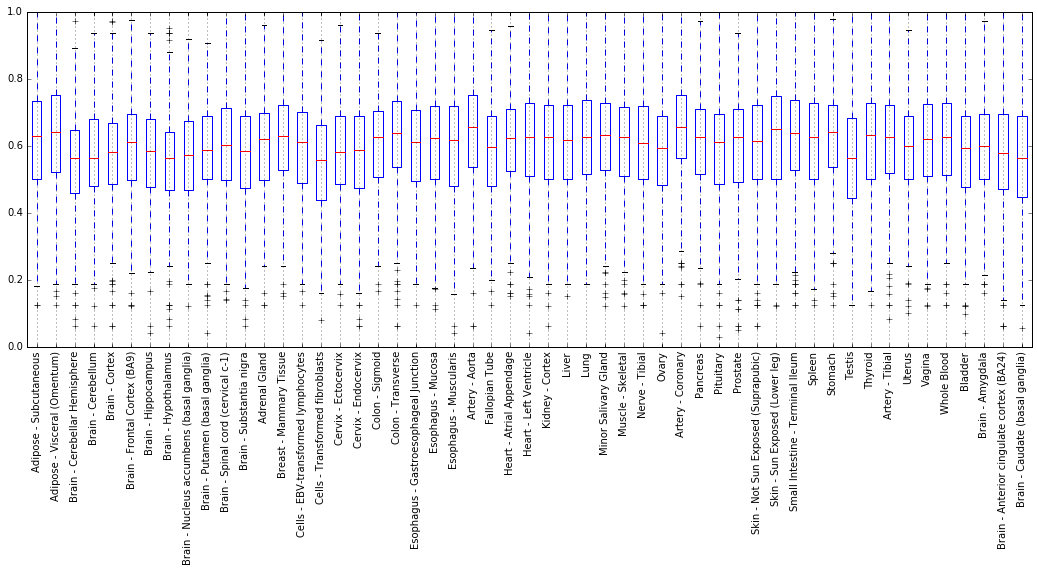

In [3]:
ipy_utils.make_boxplot(aucs, all_tissues)

Now sort the tissues by number of samples.

Observations: 
1. Tissues with more samples (i.e. more features) do not necessarily perform better than other tissues at predicting GO functions throughout the body.

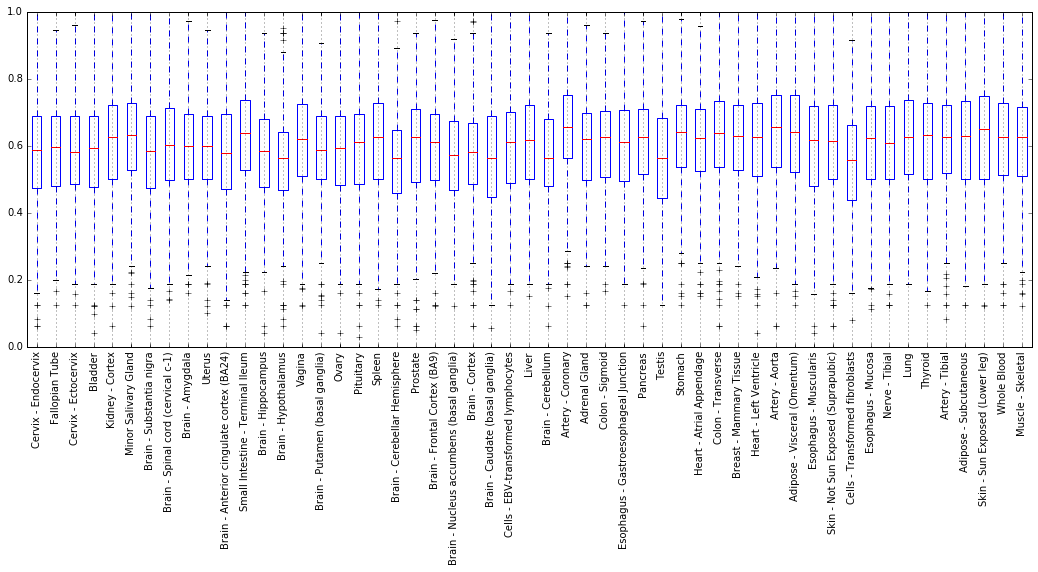

In [4]:
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order
tissues_sorted_samp = np.array(all_tissues)[index_order]
aucs_sorted_samp = np.transpose(np.transpose(aucs)[index_order])

ipy_utils.make_boxplot(aucs_sorted_samp, tissues_sorted_samp)

Try sorting tissues by number of GO terms to see if a pattern emerges.

Observations: 
1. As in the case above, there is no clear trend.

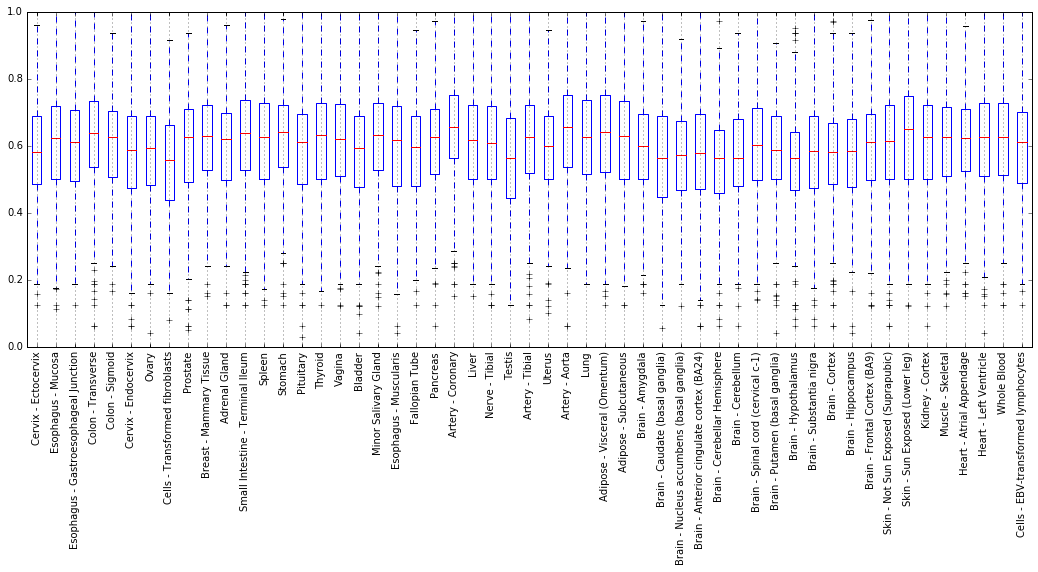

In [5]:
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted_GO = np.array(all_tissues)[index_order]
aucs_sorted_GO = np.transpose(np.transpose(aucs)[index_order])

ipy_utils.make_boxplot(aucs_sorted_GO, tissues_sorted_GO)

AUC Distributions when predicting gene-function associations using only those GO terms specific to the tissue (sorted by # GO terms)

Observations: 
1. Some tissues (such Brain and Skin) show high specificity.
2. Tissues associated with many GO terms (Cells, Whole Blood and Heart) have very high variability (maybe due to the fact that the samples associated with this tissue is heterogenous to start with or the annotation of the GO terms is highly variable)

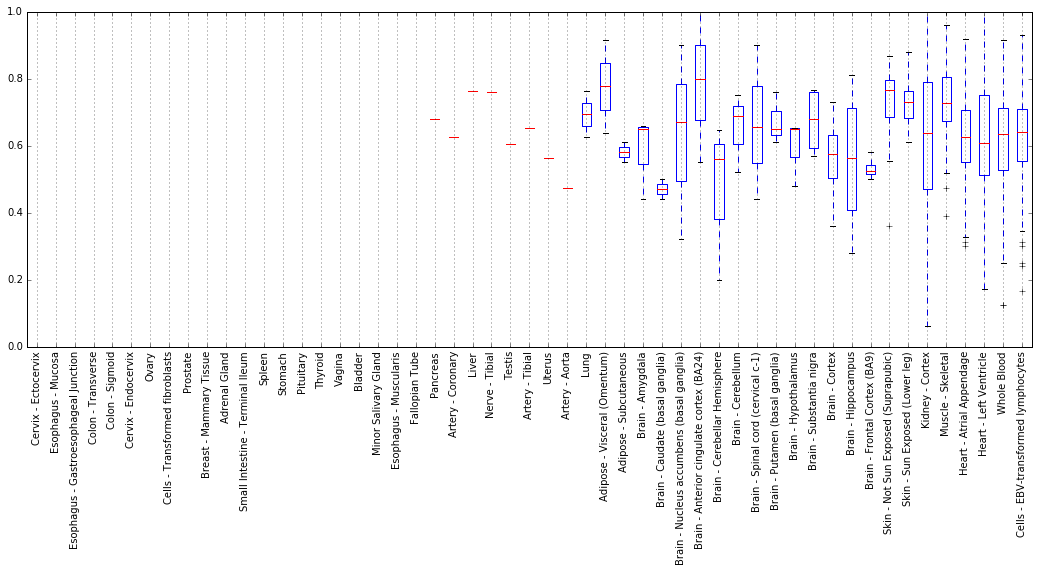

In [6]:
# For each tissue, get the AUC of each GO term that is associated with it.
aucs_spec = []
for tissue in all_tissues:
    terms = GTEX_to_GO[tissue]
    aucs_spec.append(ipy_utils.get_all_1_tissue_aucs(terms, [tissue], results_dir))
    
# Sort tissues by number of GO terms
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted = np.array(all_tissues)[index_order]
aucs_spec_sorted = np.array(aucs_spec)[index_order]
   
ipy_utils.make_boxplot(aucs_spec_sorted, tissues_sorted)

AUC Distributions using only those GO terms specific to each tissue (sort tissues by # GO terms)

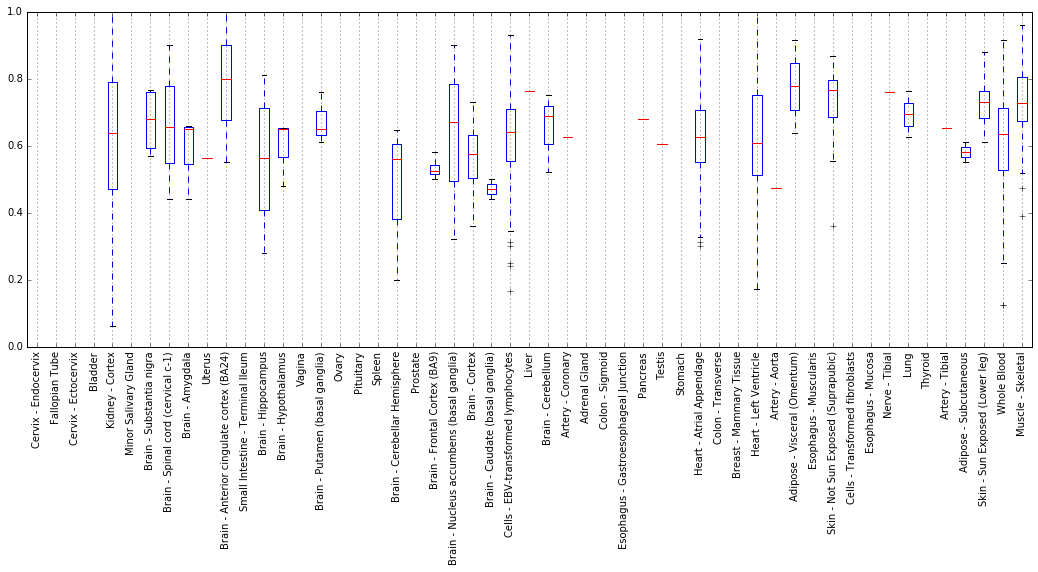

In [7]:
GTEX_to_cols = ipy_utils.map_GTEX_to_cols('../data/tissue_metadata/', all_tissues)
num_samples = [len(GTEX_to_cols[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_samples) # sort in order
tissues_spec_sorted_samp = np.array(all_tissues)[index_order]
aucs_spec_sorted_samp = np.transpose(np.transpose(aucs_spec)[index_order])

ipy_utils.make_boxplot(aucs_spec_sorted_samp, tissues_spec_sorted_samp)

"CDF" Curves. Ex: For X% of GO terms associated with a given tissue (e.g. blood), that tissue's features are in the top N AUC Scores.

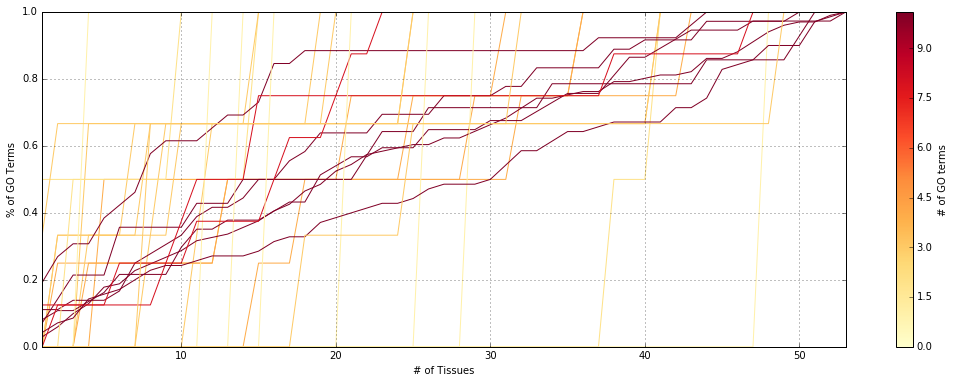

In [11]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10, tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

Same Plot as Above but color by # of Samples

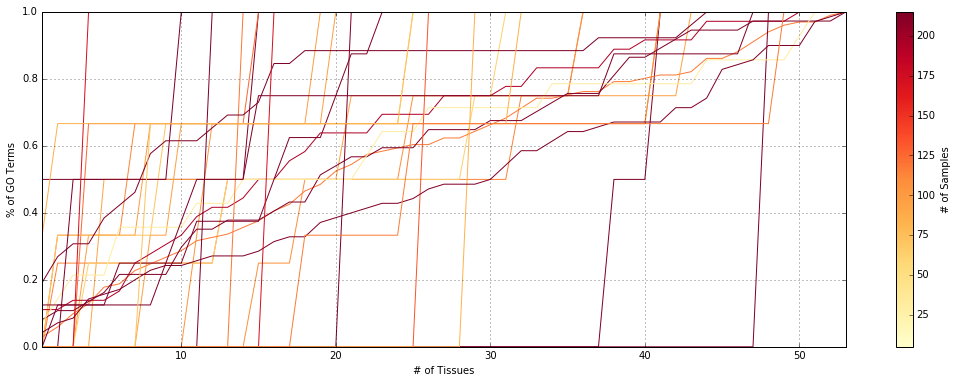

In [12]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

Now Highlight "Special" Tissues

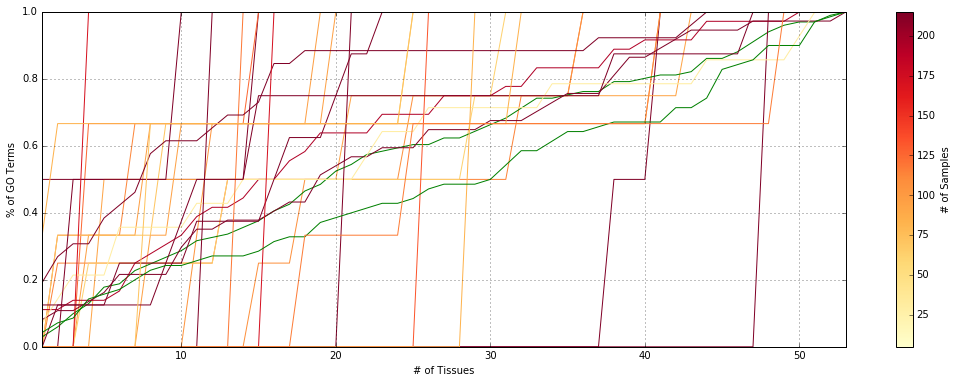

Highlighted tissues:  Cells - EBV-transformed lymphocytes, Whole Blood


In [13]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            special_tissues=special_tissues, tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

"CDF" Curves Version 2. Ex: For X% of ALL GO terms, blood features are in the top N AUC Scores.

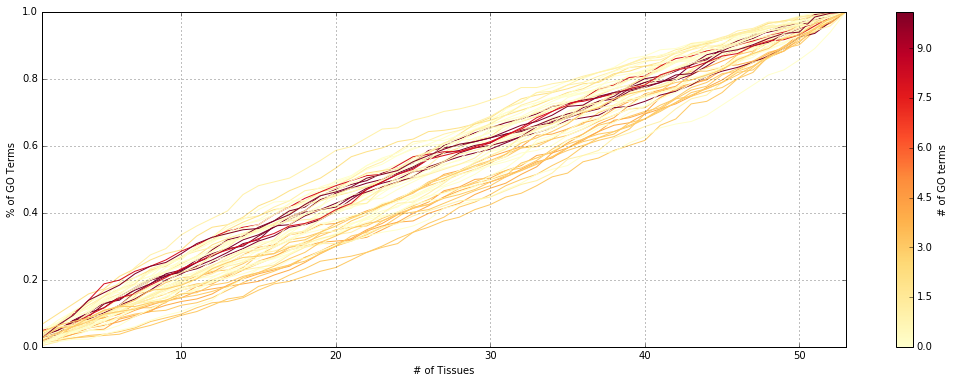

In [14]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10)

Same Curve as Above but colored by samples

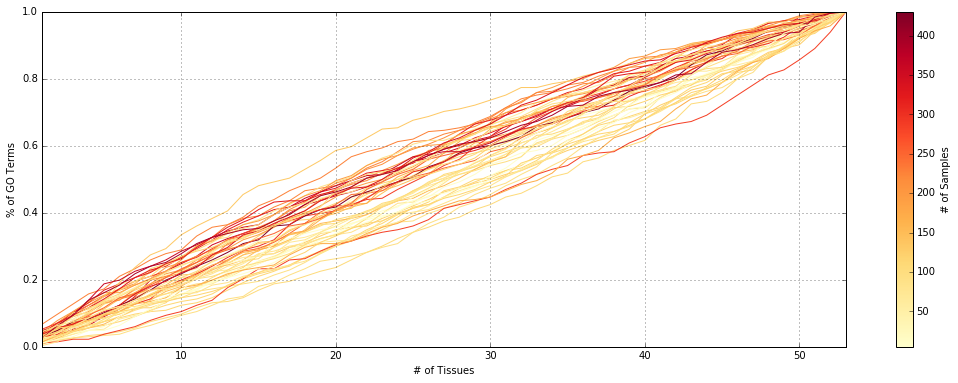

In [15]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1)

Color By Samples as Above. Also Highlight "Special" Tissues

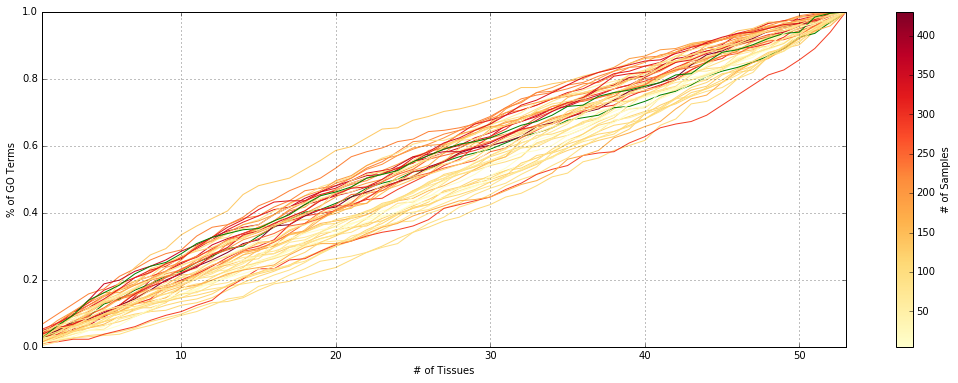

Highlighted tissues:  Cells - EBV-transformed lymphocytes, Whole Blood


In [16]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1,
            special_tissues=special_tissues)

## Results when Performing PCA Feature Reduction (use top 5 Principal Components)

In [17]:
results_dir = 'Results/pca_results_1_tissue_loss_l2_neg_0'
aucs = ipy_utils.get_all_1_tissue_aucs(GO_terms, all_tissues, results_dir)

Logistic Regression. L2 Penalty. Features for a given tissue are its top 5 principal components.

Note that L1 penalty does not necessarily make sense here since an individual tissue's features need not be sparse.

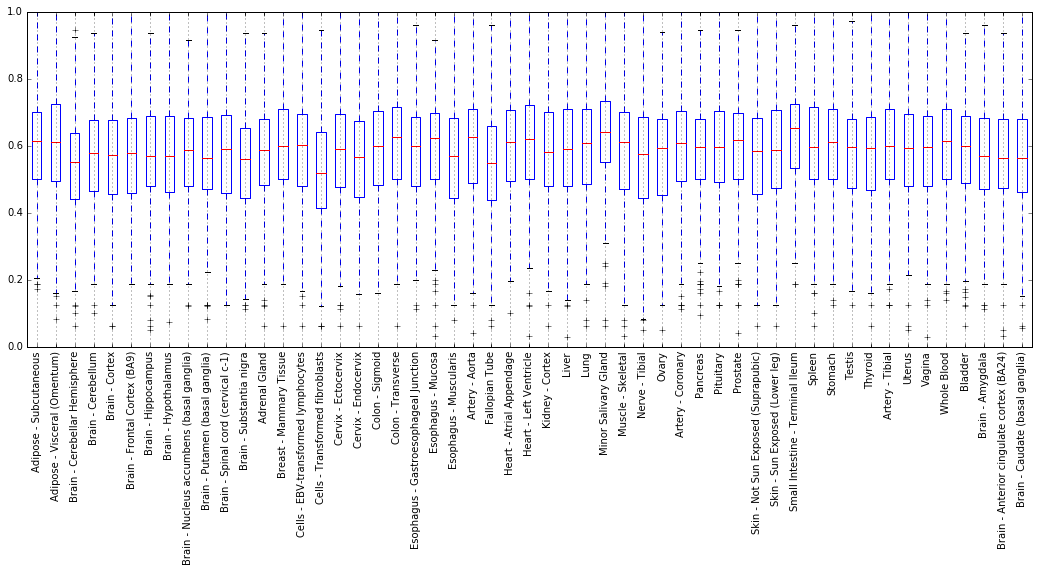

In [18]:
ipy_utils.make_boxplot(aucs, all_tissues)

Show only predictions of GO terms that each tissue is annotated with

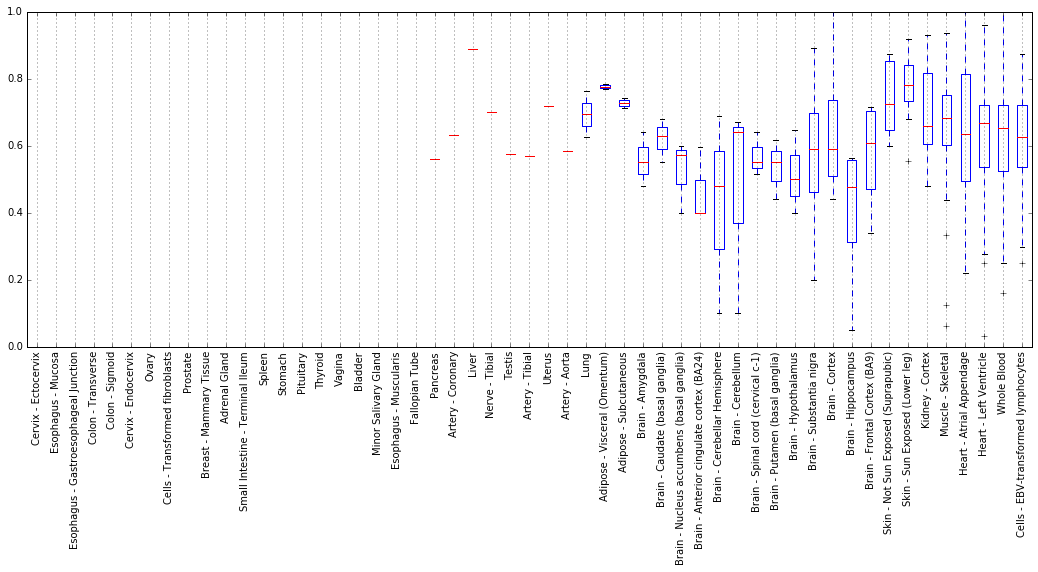

In [19]:
# For each tissue, get the AUC of each GO term that is associated with it.
aucs_spec = []
for tissue in all_tissues:
    terms = GTEX_to_GO[tissue]
    aucs_spec.append(ipy_utils.get_all_1_tissue_aucs(terms, [tissue], results_dir))
    
# Sort tissues by number of GO terms
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted = np.array(all_tissues)[index_order]
aucs_spec_sorted = np.array(aucs_spec)[index_order]
   
ipy_utils.make_boxplot(aucs_spec_sorted, tissues_sorted)

Empirical "CDF" For L2 Norm, Single Tissue Features (Dimen-Reduced Using PCA)

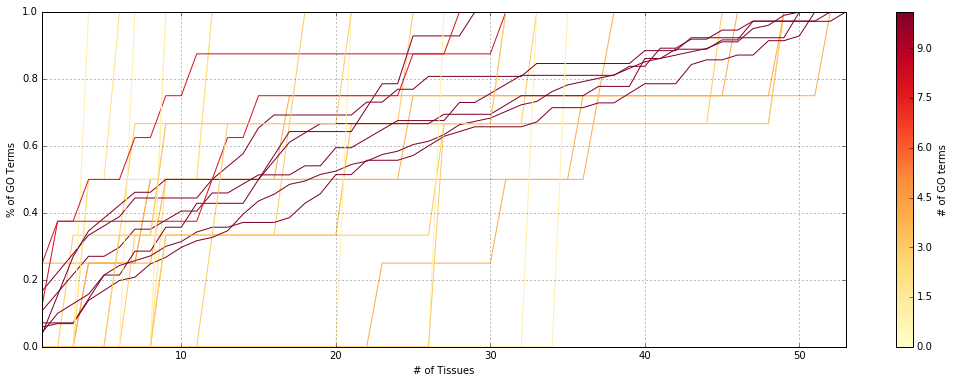

In [20]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

Same as Above, But Heatmap by # of Samples Of this Tissue.

Suggests that when there are more samples, the features derived from PCA are more reliable.

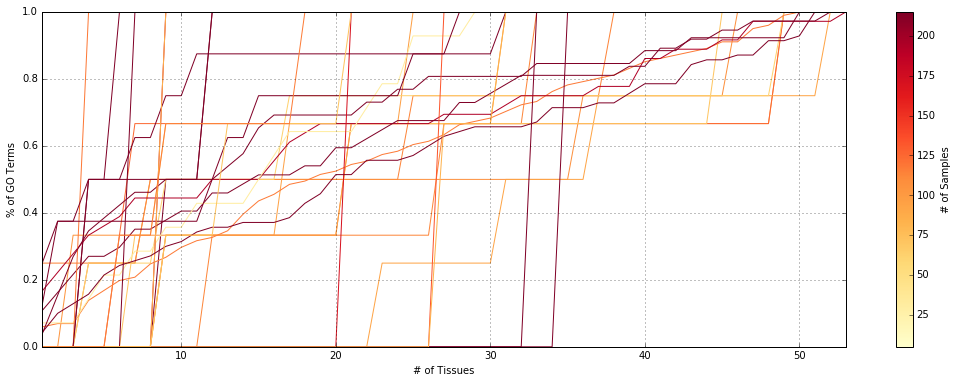

In [21]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

CDF Curves For ALL GO Terms (Not just those associated w/the Tissue)

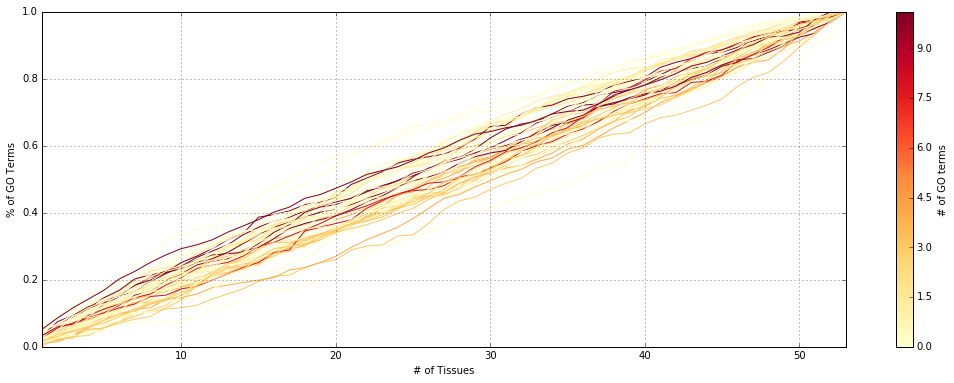

In [22]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10)

Same as Above but colored by # of samples of each tissue.

Notice that the tissues with many samples no longer dominate. This was the purpose of using features derived from PCA.

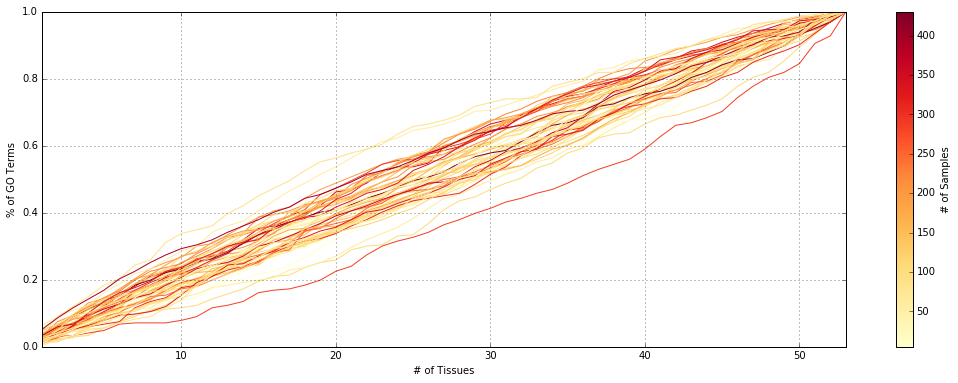

In [23]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1)

## Results when Performing Median Feature Reduction 

In [24]:
results_dir = 'Results/median_results_1_tissue_loss_l2_neg_0'
aucs = ipy_utils.get_all_1_tissue_aucs(GO_terms, all_tissues, results_dir)

Logistic Regression. L2 Penalty. Feature for a given tissue is the median.
Note that L1 penalty does not necessarily make sense here since an individual tissue's features need not be sparse.

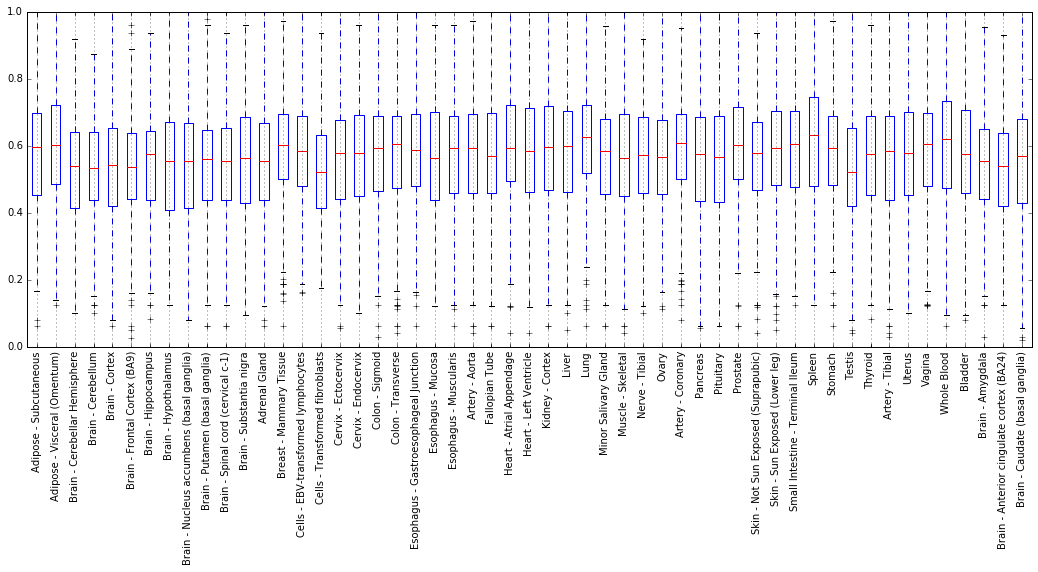

In [25]:
ipy_utils.make_boxplot(aucs, all_tissues)

Show only predictions of GO terms that each tissue is annotated with

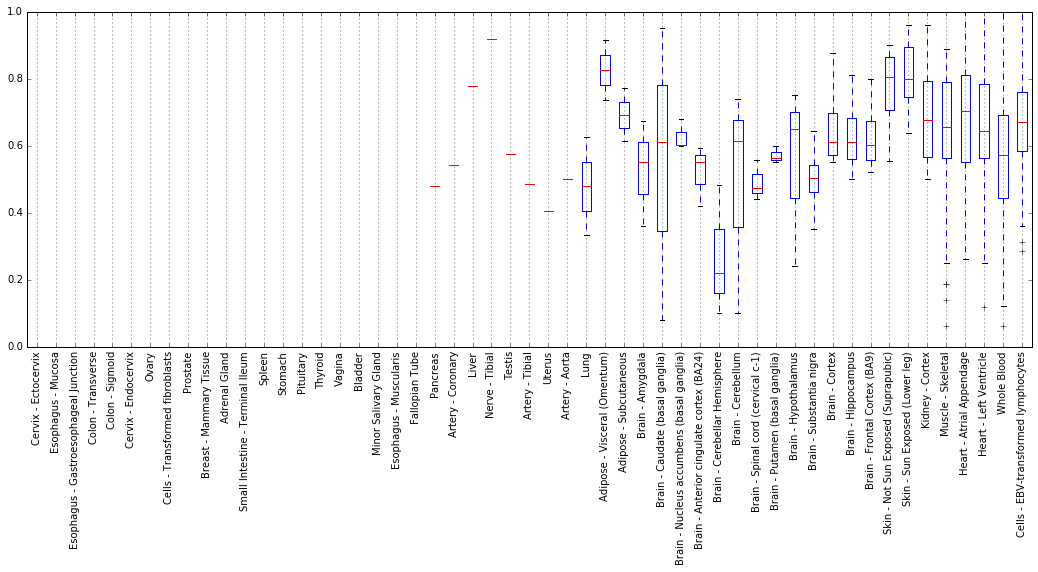

In [26]:
# For each tissue, get the AUC of each GO term that is associated with it.
aucs_spec = []
for tissue in all_tissues:
    terms = GTEX_to_GO[tissue]
    aucs_spec.append(ipy_utils.get_all_1_tissue_aucs(terms, [tissue], results_dir))
    
# Sort tissues by number of GO terms
num_GO = [len(GTEX_to_GO[tissue]) for tissue in all_tissues]
index_order = np.argsort(num_GO) # sort in order
tissues_sorted = np.array(all_tissues)[index_order]
aucs_spec_sorted = np.array(aucs_spec)[index_order]
   
ipy_utils.make_boxplot(aucs_spec_sorted, tissues_sorted)

Empirical "CDF" For L2 Norm, Single Tissue Features (Median feature)

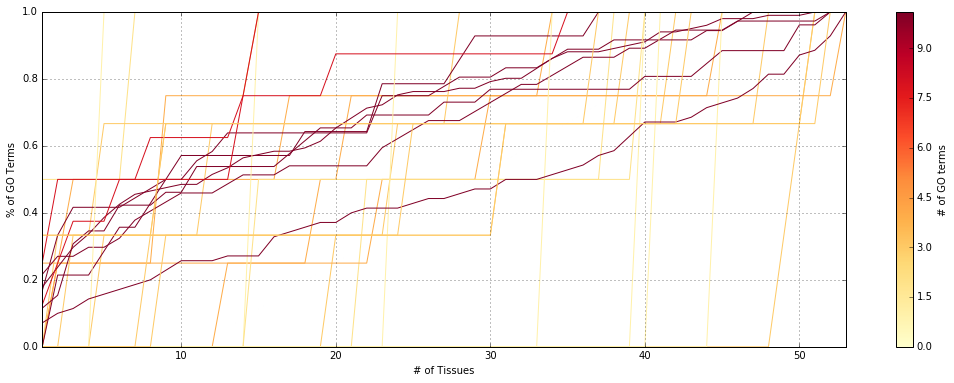

In [27]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

Same as Above, But Heatmap by # of Samples Of this Tissue.

Suggests that when there are more samples, the median feature is not necessarily more reliable.

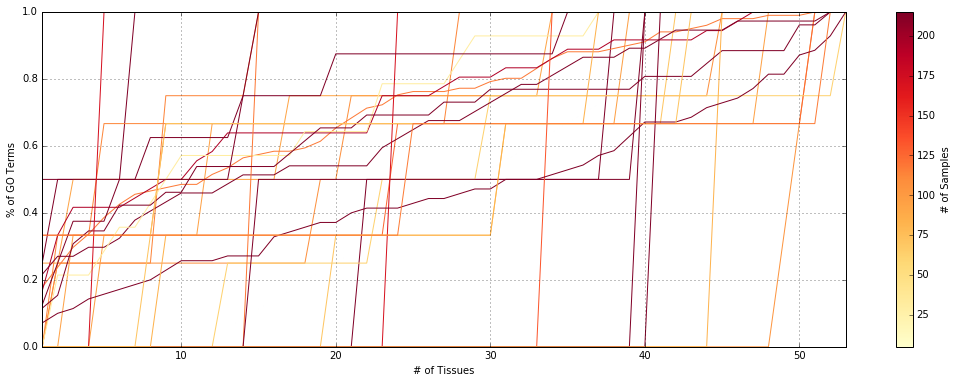

In [29]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=2,
            tissue_specific_GO=True, gtex_to_go_map=GTEX_to_GO)

CDF Curves For ALL GO Terms (Not just those associated w/the Tissue)

Notice the high values at the bottom left for tissues with many GO terms. However, this high value then tapers off. May suggest that some GO terms are just not very tissue specific.

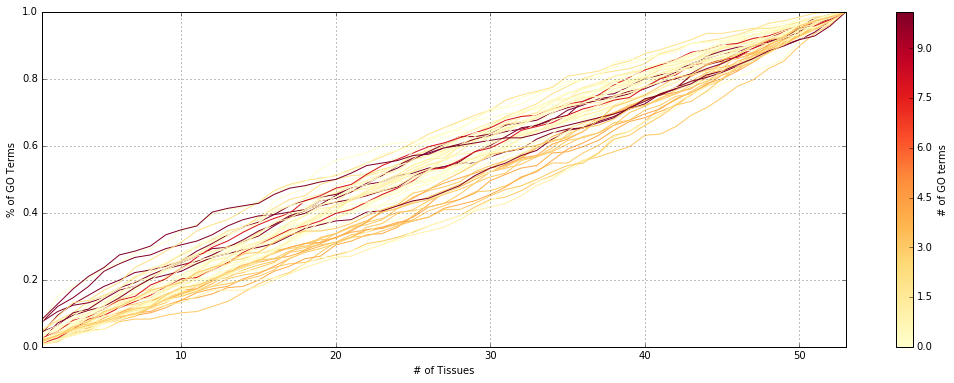

In [30]:
plot_emp_cdf(aucs, all_tissues, GO_terms, GO_counts, '# of GO terms', hmap_normalization=10)

 Same as Above but colored by # of samples of each tissue.

As in the case of PCA, notice that the tissues with many samples no longer dominate. 

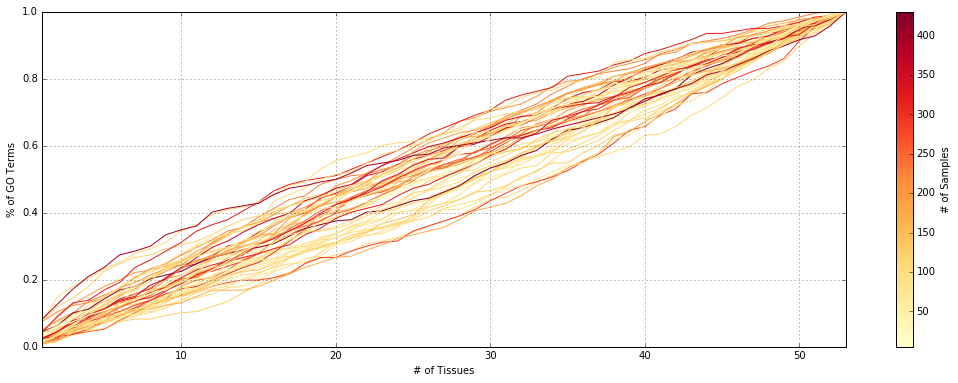

In [31]:
plot_emp_cdf(aucs, all_tissues, GO_terms, sample_counts, '# of Samples', hmap_normalization=1)

In [ ]:
## In case you need to fix folders with _server postfix.
results_path = 'pca_results_1_tissue_L1/'
results_dir = [f for f in listdir(results_path) if join(results_path, f)]

for d in results_dir:
    if 'server' in d:
        server_index = d.index('server')
        new_d = d[:server_index-1]
        if not exists(new_d):
            makedirs(results_path + new_d)
        
        rename(results_path + d, results_path + new_d)